# Предсказание температуры стали

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Нам предстоит построить модель, которая предскажет температуру стали.

## Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

## План

- Загрузить данные и ознакомиться с ними;
- Провести графический анализ данных;
- Выполнить предобработку данных: заполнить пропуски, привести данные к корректным типам и т.д.;
- Подготовить данные для обучения моделей:
    - сформировать итоговый датафрейм;
    - выделить целевой признак;
    - сформировать обучающую и тестовую выборки.
- Обучить модели:
    - линейная регрессия;
    - дерево решений;
    - случайный лес;
    - CatBoost.
- Протестировать модели с помощью кросс-валидации и оценить важность факторов.
- Итоговый вывод

## Исследовательский анализ данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

In [2]:
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [3]:
RANDOM_STATE = 120623

In [4]:
ds_names = ['data_arc_new', 'data_bulk_new', 'data_bulk_time_new', 'data_gas_new',
            'data_temp_new', 'data_wire_new', 'data_wire_time_new']

datasets = {}

In [5]:
def read_datasets(data_name):
    data = pd.read_csv(f'/datasets/{data_name}.csv')
    
    datasets[data_name] = data

In [6]:
for ds_name in ds_names:
    read_datasets(ds_name)

In [7]:
for ds_name, ds in datasets.items():
    print(ds_name)
    display(ds.head(10))
    print('\n')

data_arc_new


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856




data_bulk_new


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0




data_bulk_time_new


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47
5,6,NaN,NaN,NaN,2019-05-03 13:57:27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:48:52,NaN,2019-05-03 14:09:42,2019-05-03 14:03:15
6,7,NaN,NaN,NaN,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:41:26,NaN,2019-05-03 14:30:50,2019-05-03 14:27:16
7,8,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,2019-05-03 15:13:18,2019-05-03 15:05:33
8,9,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,2019-05-03 16:00:16,2019-05-03 15:52:39
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:38:11,NaN,2019-05-03 16:34:24,2019-05-03 16:29:56




data_gas_new


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891




data_temp_new


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0




data_wire_new


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN




data_wire_time_new


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:57:27,2019-05-03 13:48:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:01:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:45:44,2019-05-03 15:39:37,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:27:00,2019-05-03 16:22:36,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
def convert_to_date(ds_name, col_name):
    datasets[ds_name][col_name] = pd.to_datetime(datasets[ds_name][col_name], format='%Y-%m-%d %H:%M:%S')

In [9]:
convert_to_date('data_arc_new', 'Начало нагрева дугой')
convert_to_date('data_arc_new', 'Конец нагрева дугой')
convert_to_date('data_temp_new', 'Время замера')

for bulk in datasets['data_bulk_time_new'].columns.to_list()[1:]:
    convert_to_date('data_bulk_time_new', bulk)
    
for wire in datasets['data_wire_time_new'].columns.to_list()[1:]:
    convert_to_date('data_wire_time_new', wire)

In [10]:
for ds_name, ds in datasets.items():
    print(ds_name)
    ds.info()
    print('=' * 60)
    print('\n')

data_arc_new
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


data_bulk_new
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5  

In [11]:
for ds_name, ds in datasets.items():
    print(ds_name)
    display(ds.describe())
    print('\n')

data_arc_new


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284




data_bulk_new


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000




data_bulk_time_new


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000




data_gas_new


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040




data_temp_new


,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000




data_wire_new


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604




data_wire_time_new


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


Проверяем наличие дубликатов в таблицах.

In [12]:
for ds_name, ds in datasets.items():
    print(ds_name)
    print(ds.duplicated().sum())
    print('=' * 20)
    print('\n')

data_arc_new
0


data_bulk_new
0


data_bulk_time_new
0


data_gas_new
0


data_temp_new
0


data_wire_new
0


data_wire_time_new
0




Проверяем уникальные значения `key` в таблицах.

In [13]:
for ds_name, ds in datasets.items():
    print(ds_name)
    print(len(ds['key'].unique()))
    print('=' * 20)
    print('\n')

data_arc_new
3214


data_bulk_new
3129


data_bulk_time_new
3129


data_gas_new
3239


data_temp_new
3216


data_wire_new
3081


data_wire_time_new
3081




Проверим, в одних и тех же строках пропуски в датасетах `data_bulk_time_new` и `data_bulk_new`; `data_wire_time_new` и `data_wire_new`

In [14]:
print((datasets['data_bulk_time_new'].isna() == datasets['data_bulk_new'].isna()).sum())

key        3129
Bulk 1     3129
Bulk 2     3129
Bulk 3     3129
Bulk 4     3129
Bulk 5     3129
Bulk 6     3129
Bulk 7     3129
Bulk 8     3129
Bulk 9     3129
Bulk 10    3129
Bulk 11    3129
Bulk 12    3129
Bulk 13    3129
Bulk 14    3129
Bulk 15    3129
dtype: int64


In [15]:
print((datasets['data_wire_time_new'].isna() == datasets['data_wire_new'].isna()).sum())

key       3081
Wire 1    3081
Wire 2    3081
Wire 3    3081
Wire 4    3081
Wire 5    3081
Wire 6    3081
Wire 7    3081
Wire 8    3081
Wire 9    3081
dtype: int64


### Вывод

- Во всех таблицах, кроме `data_arc_new` и `data_gas_new` присутствуют пропуски в данных.
- В таблице `data_arc_new` присутствует отрицательное значение реактивной мощности. Скорее всего такое значение придется удалить на этапе предобработки.
- В датасетах дубликаты отсутствуют.
- Количество уникальных `key` - номеров партии - в датасетах разное, следовательно, при создании общей таблицы некоторые данные будут незаполнены.
- В датасетах `data_bulk_time_new` и `data_bulk_new` присутствуют пропуски в одних и тех же местах. Вероятнее всего, это просто отсутствие засыпки на конкретном этапе обработки.
- В датасетах `data_wire_time_new` и `data_wire_new` также присутствуют пропуски в одинаковых местах. Велика вероятность, что это просто отсутсвие подачи проволоки на определенном этапе.
- На этапе предобработки имеет смысл привести наименования столбцов к одному стилю.

## Графический анализ данных

### data_arc_new

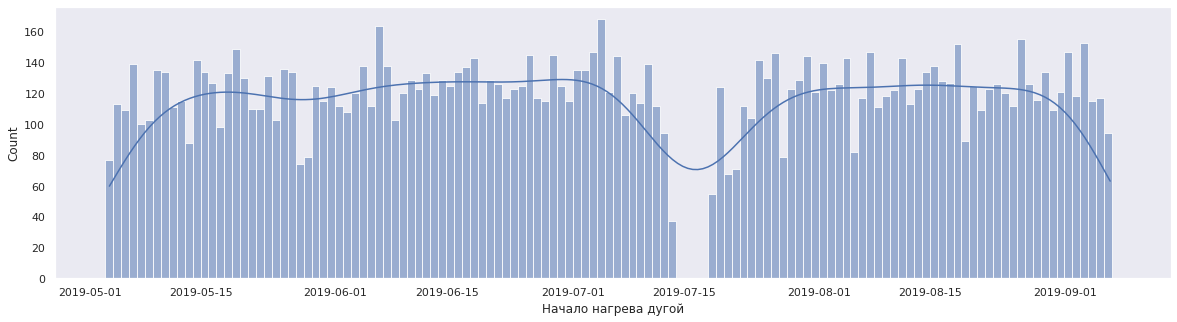

In [16]:
sns.set(rc={'figure.figsize': (20, 5)})
sns.set_style('dark')
sns.histplot(data=datasets['data_arc_new'], x='Начало нагрева дугой', kde=True, discrete=True);

Присутствует пропуск в седьмом месяце.

In [17]:
datasets['data_arc_new']['Начало нагрева дугой'].dt.day[datasets['data_arc_new']['Начало нагрева дугой'].dt.month==7].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

Отсутствуют данные за период с 14 по 17 числа включительно.

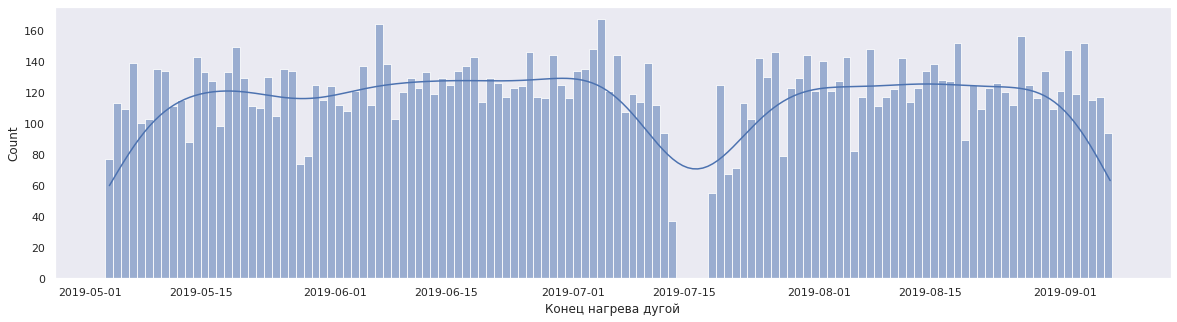

In [18]:
sns.set(rc={'figure.figsize': (20, 5)})
sns.set_style('dark')
sns.histplot(data=datasets['data_arc_new'], x='Конец нагрева дугой', kde=True, discrete=True);

In [19]:
datasets['data_arc_new']['Конец нагрева дугой'].dt.day[datasets['data_arc_new']['Конец нагрева дугой'].dt.month==7].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

Аналогично присутствует пропуск в периоде с 14 по 17 числа.

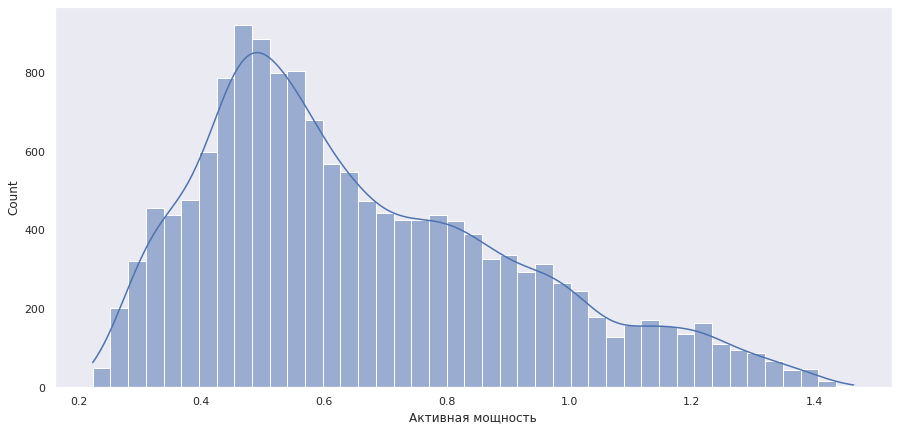

In [20]:
sns.set(rc={'figure.figsize': (15, 7)})
sns.set_style('dark')
sns.histplot(data=datasets['data_arc_new'], x='Активная мощность', kde=True);

Распределение активной мощности похоже на нормальное со смещением влево.

### data_bulk_new

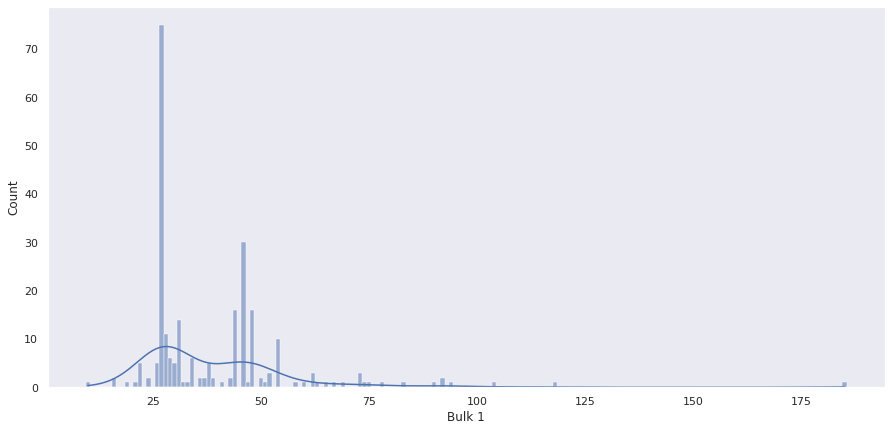

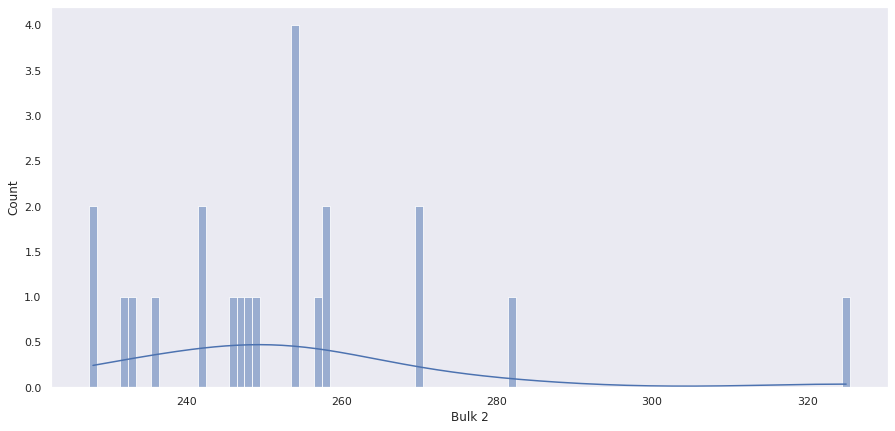

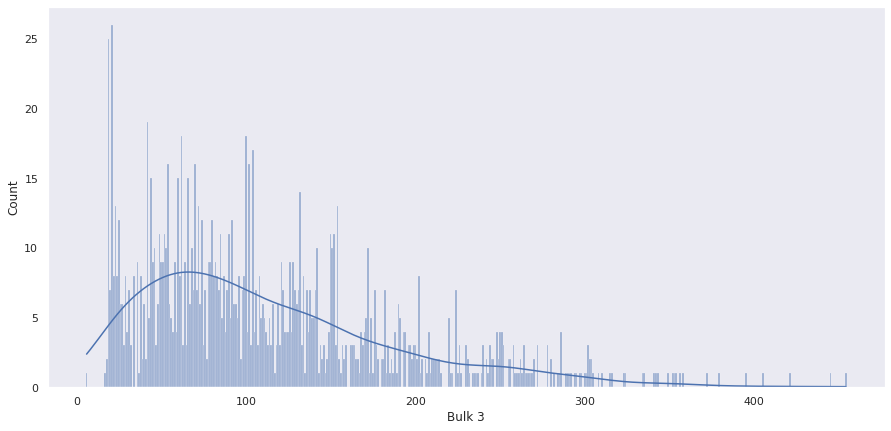

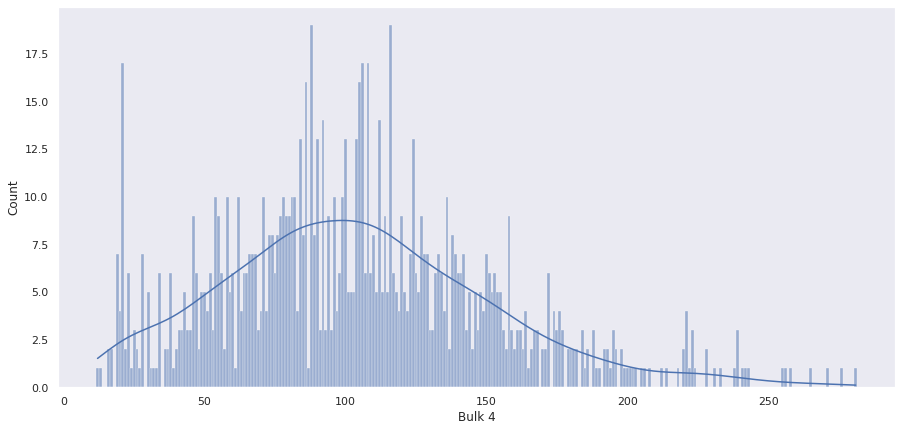

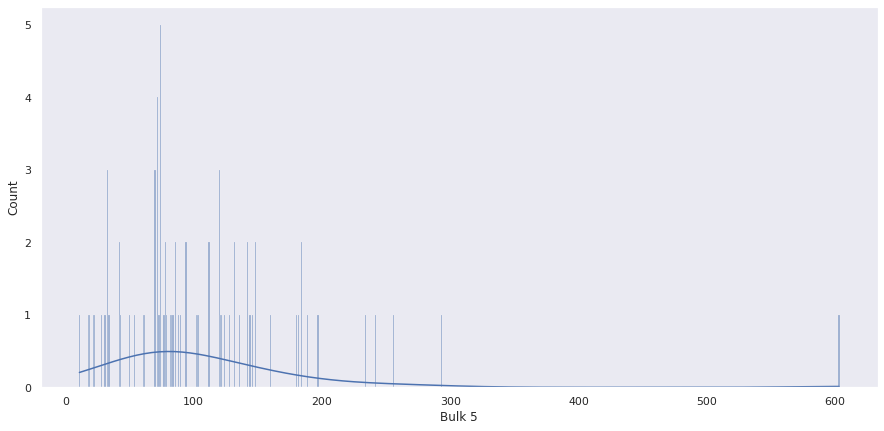

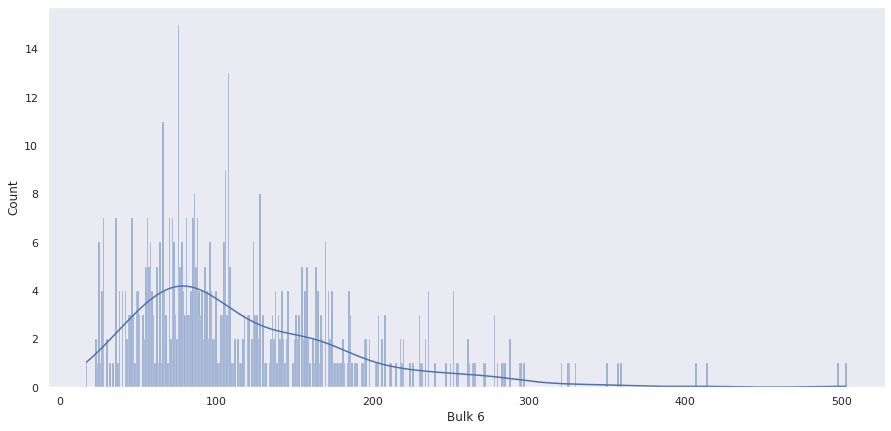

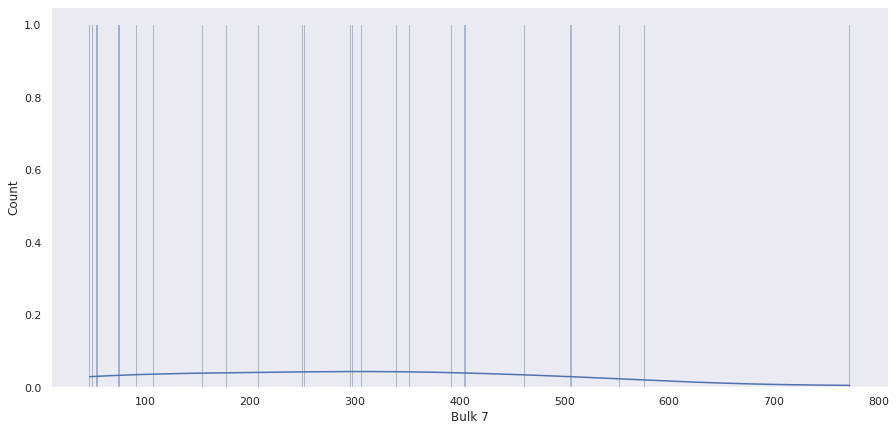

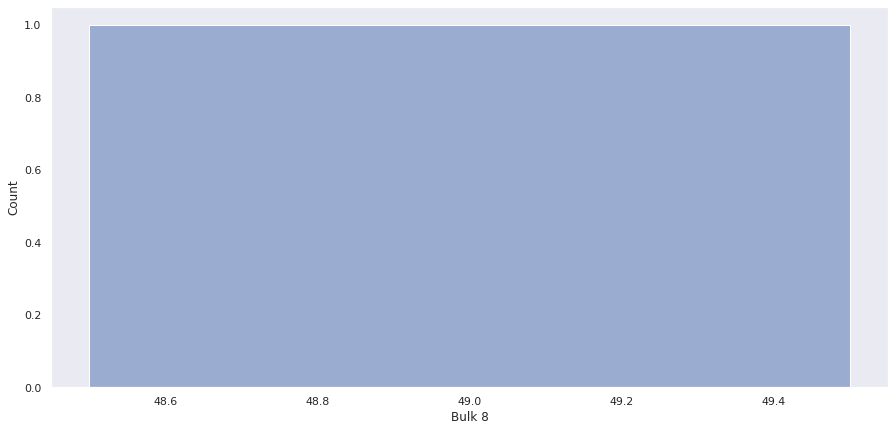

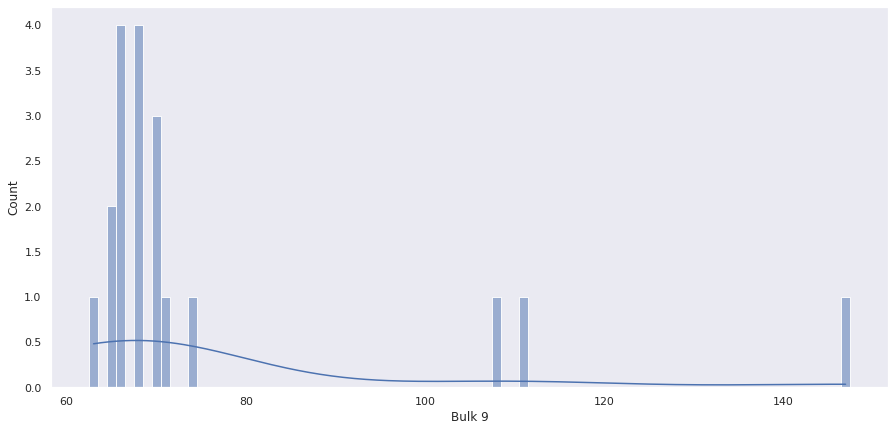

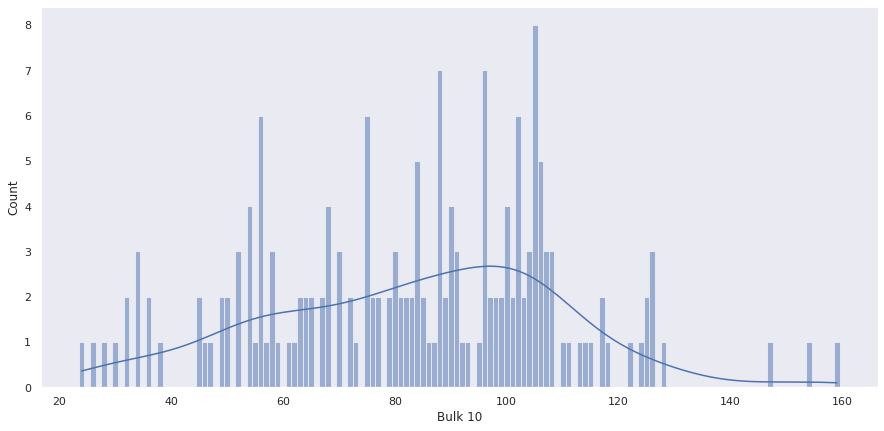

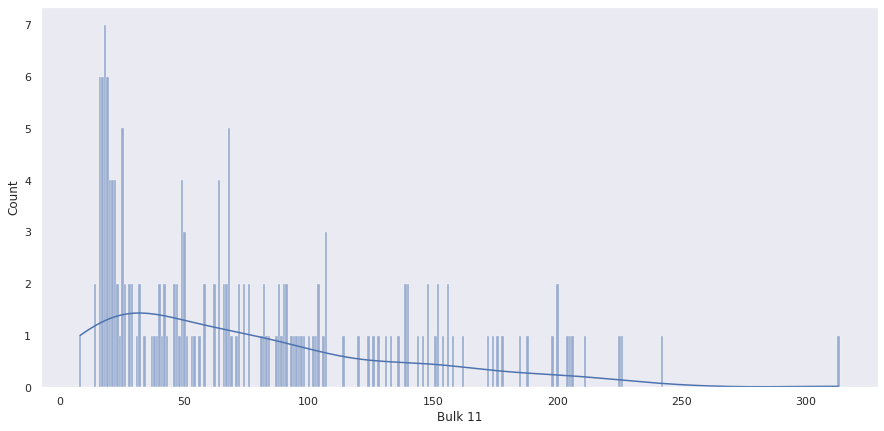

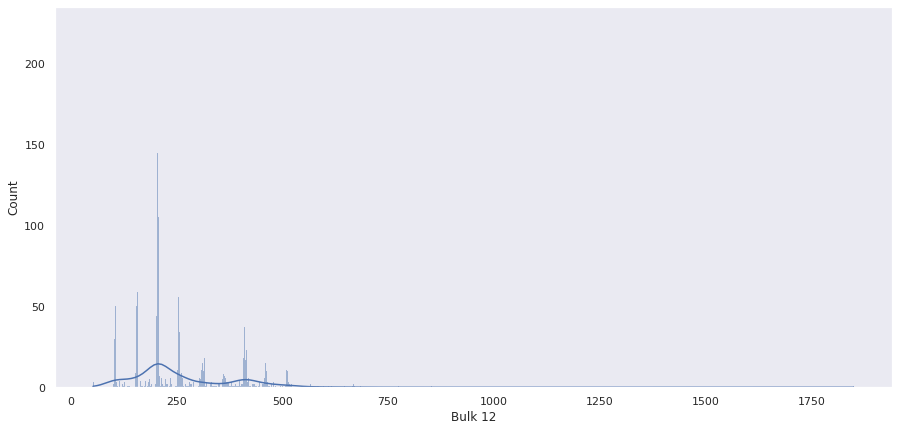

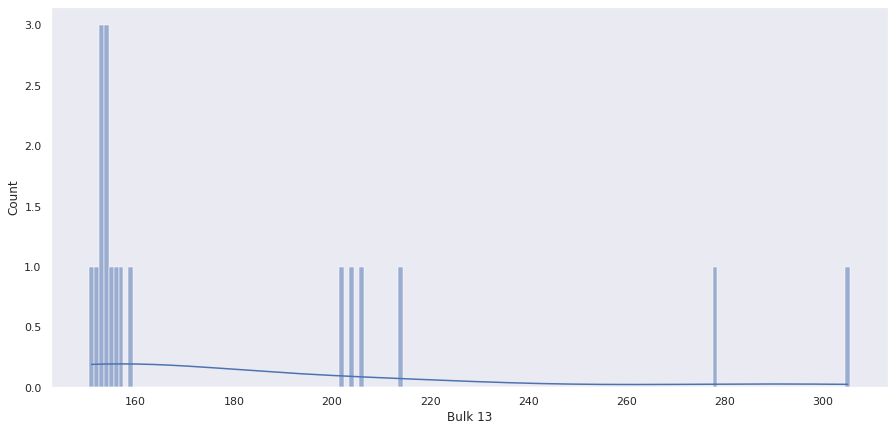

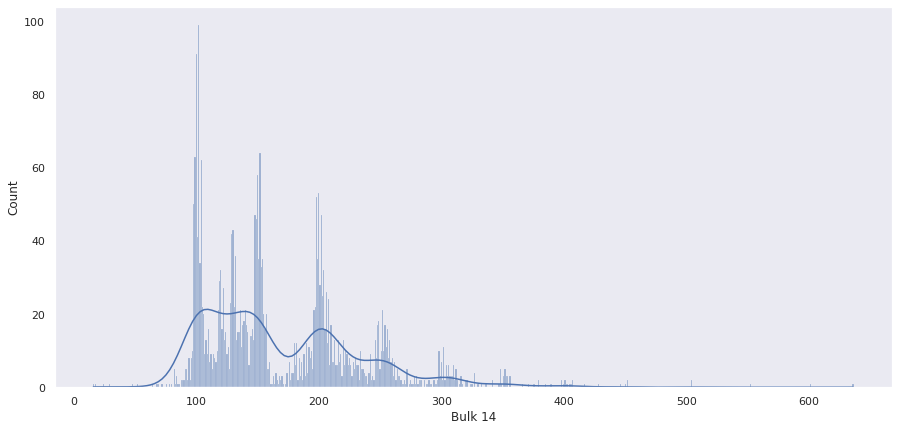

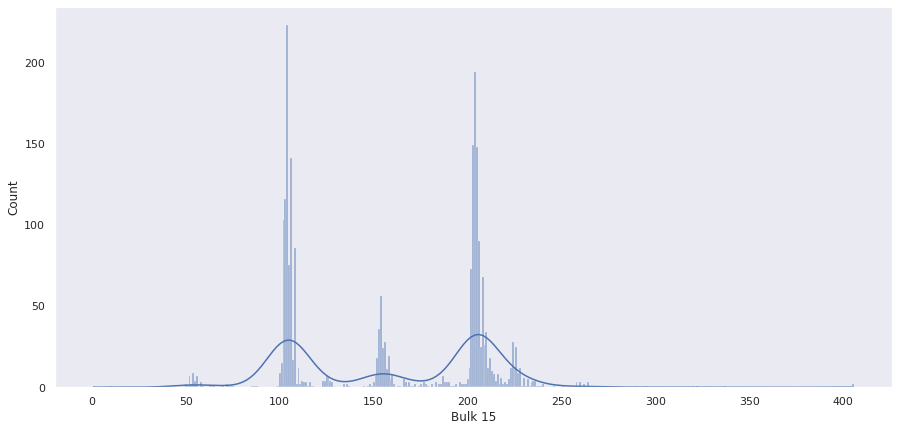

In [21]:
bulks = datasets['data_bulk_new'].columns.to_list()[1:]

for bulk in bulks:
    sns.set(rc={'figure.figsize': (15, 7)})
    sns.set_style('dark')
    sns.histplot(data=datasets['data_bulk_new'], x=bulk, kde=True, discrete=True)
    plt.show()

In [22]:
datasets['data_bulk_new'].describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Какой-либо определенной закономерности в добавлении сыпучих материалов нет. Заметно, что добавляются они в определенных количествах.

Также можно увидеть, что чаще всего добавляются `Bulk 12`, `Bulk 14` и `Bulk 15`. В то же время `Bulk 8` была добавлена всего один раз.

### data_bulk_time_new

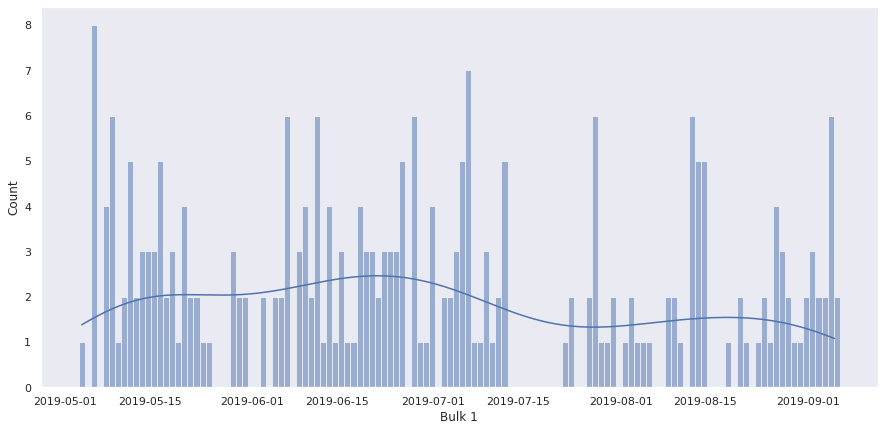

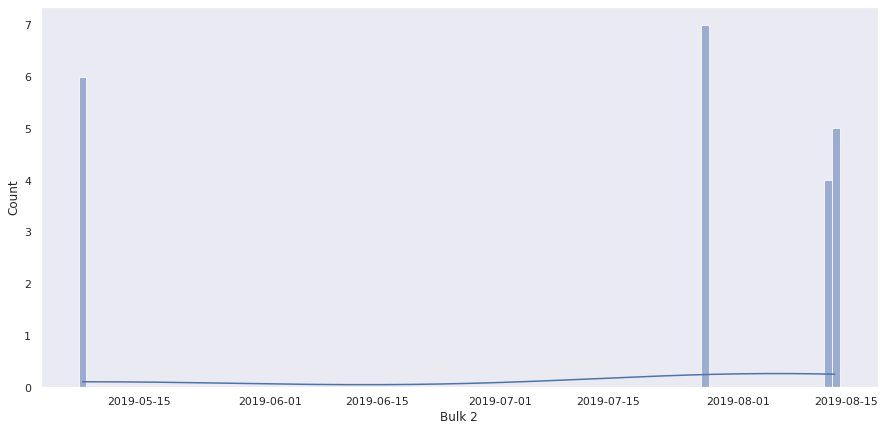

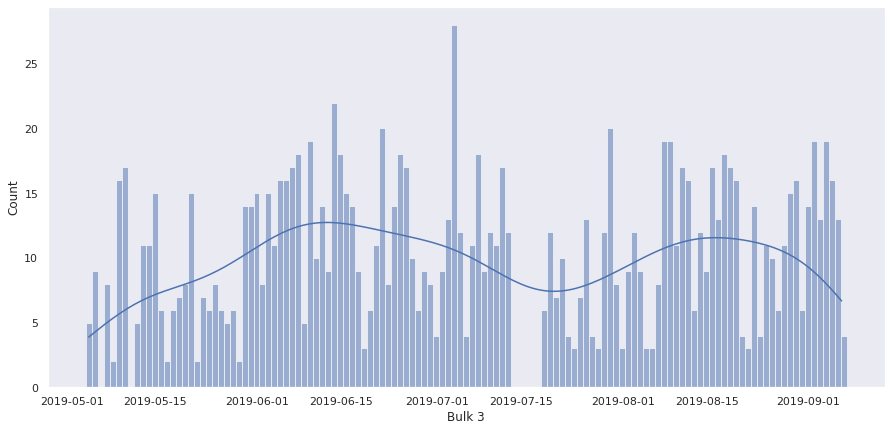

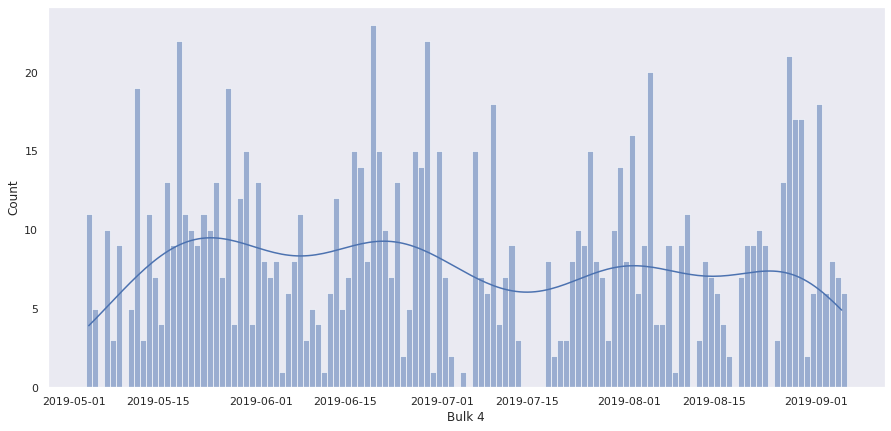

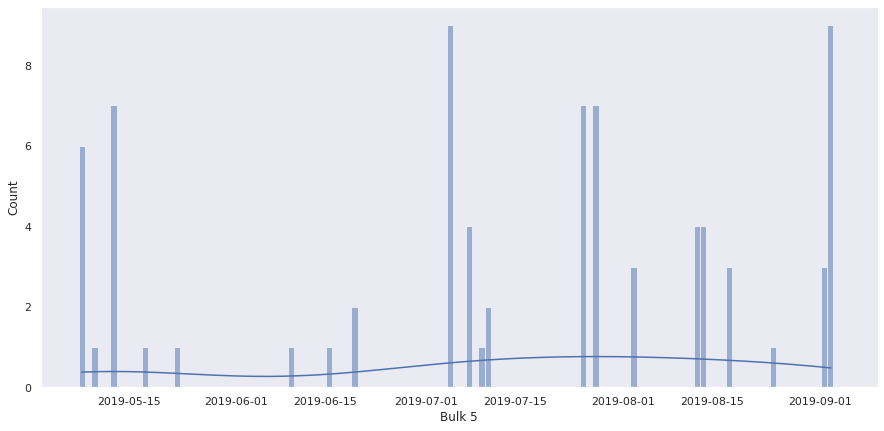

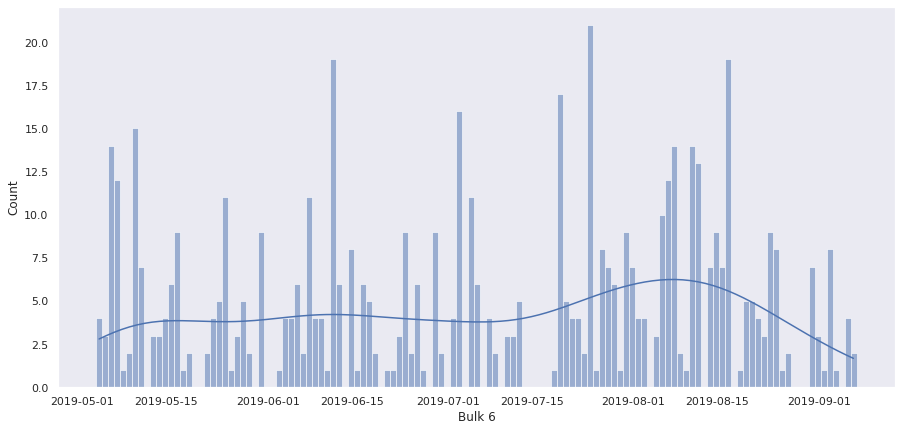

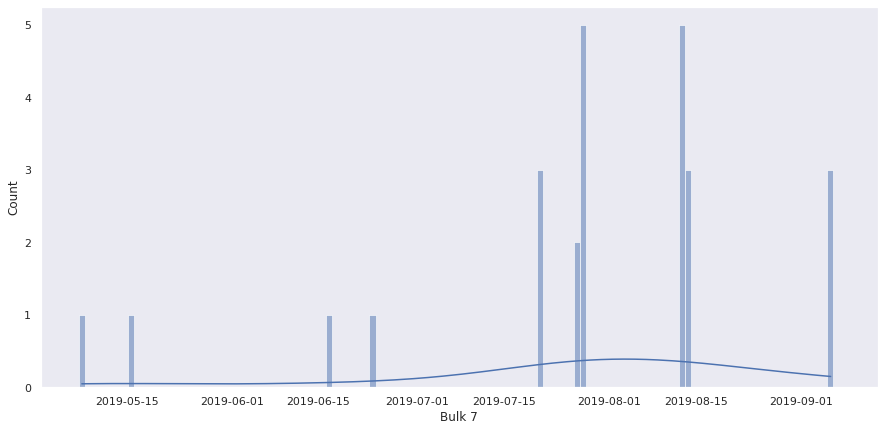

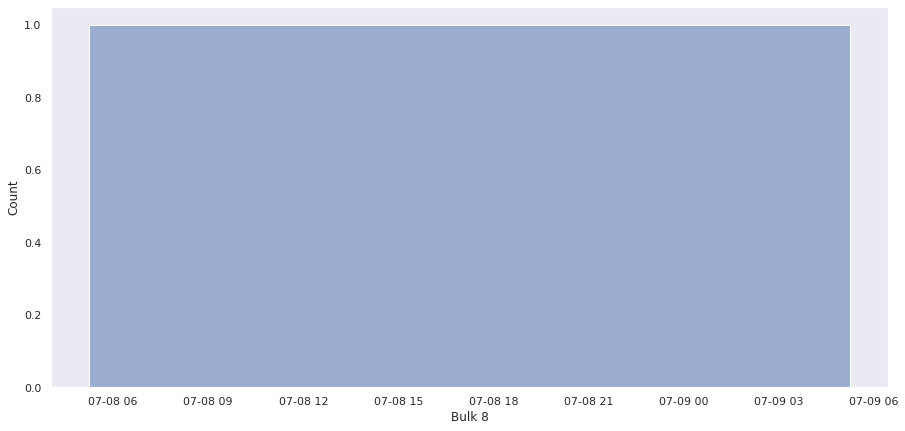

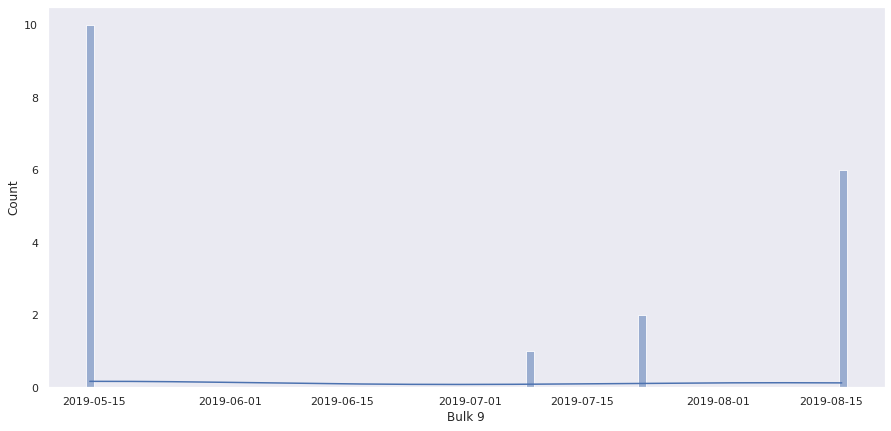

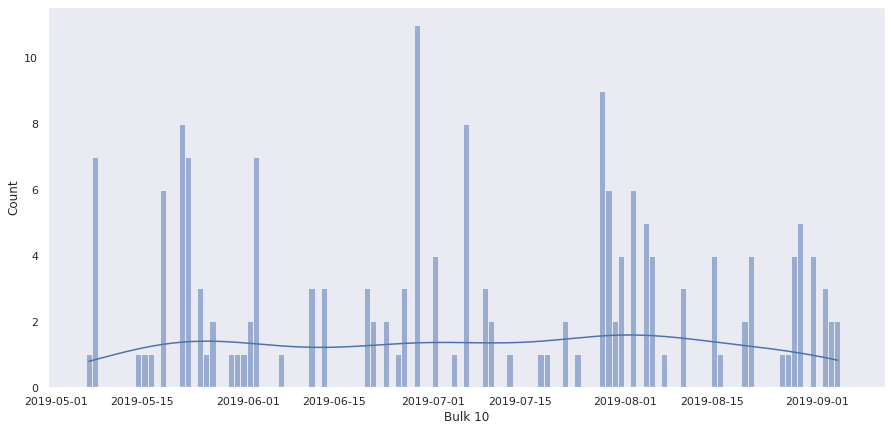

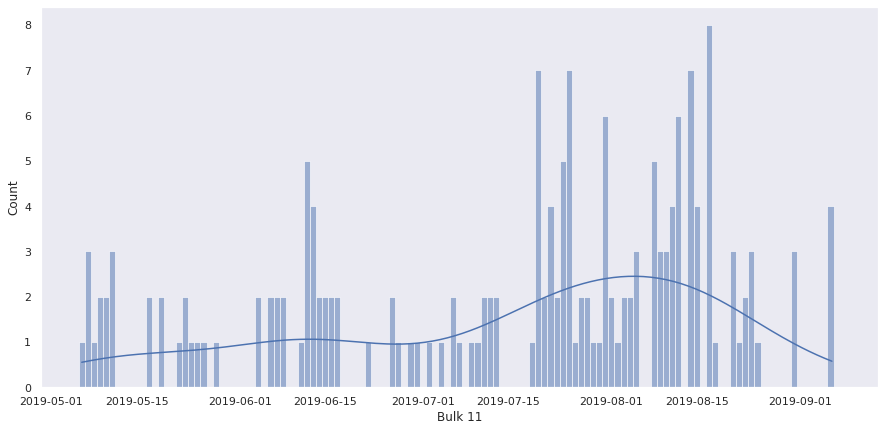

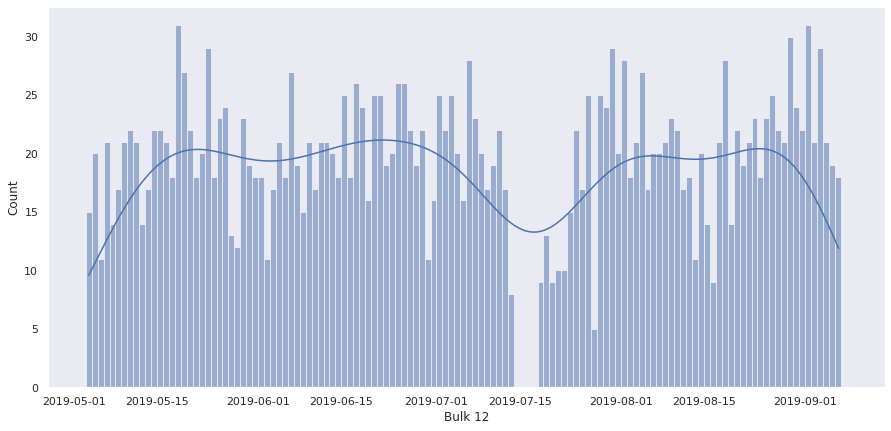

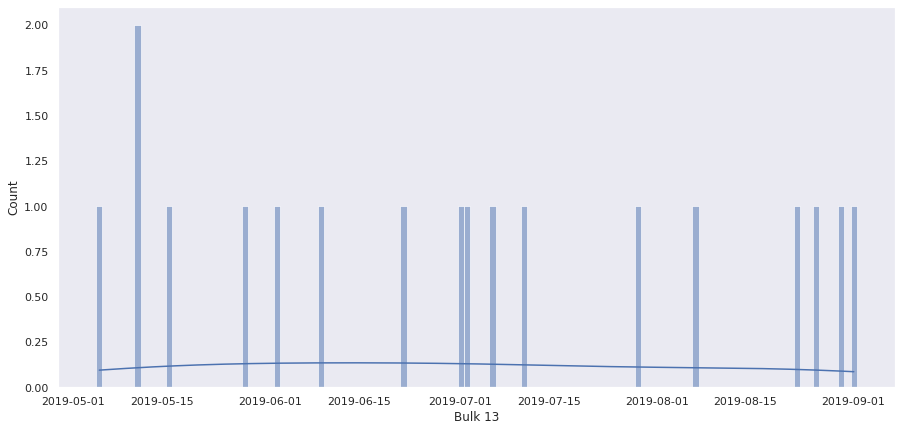

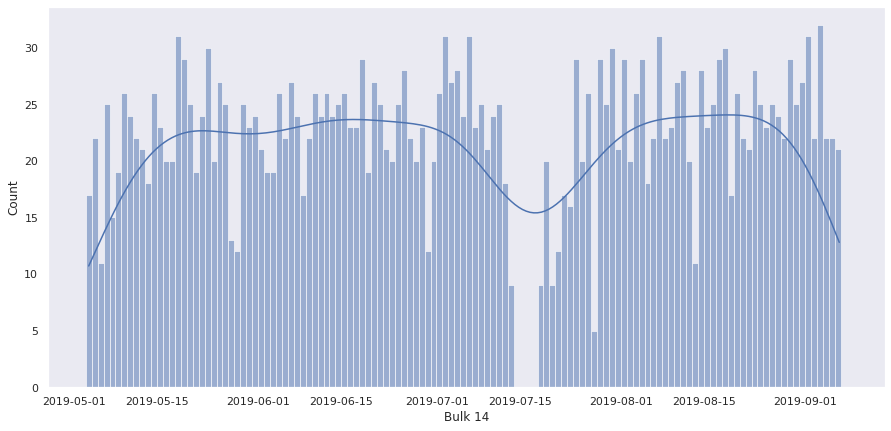

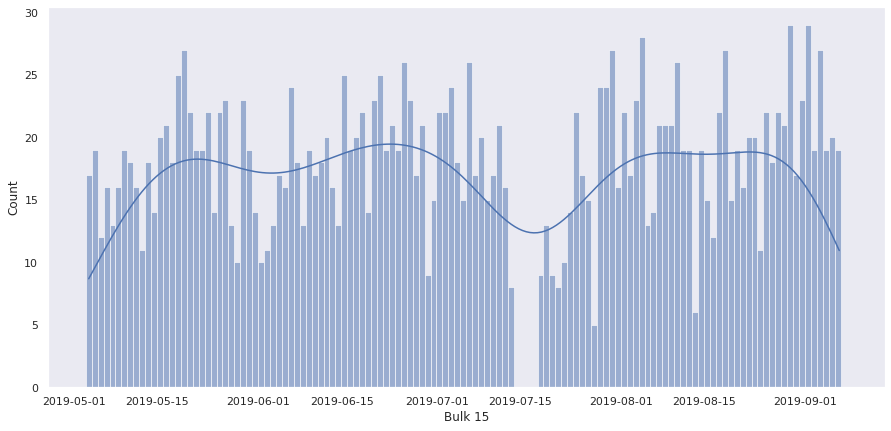

In [23]:
for bulk in bulks:
    sns.set(rc={'figure.figsize': (15, 7)})
    sns.set_style('dark')
    sns.histplot(data=datasets['data_bulk_time_new'], x=bulk, kde=True, discrete=True)
    plt.show()

Закономерности также не наблюдается. Можно увидеть тот же пропуск в данных за период с 14 по 17 июля.

### data_gas_new

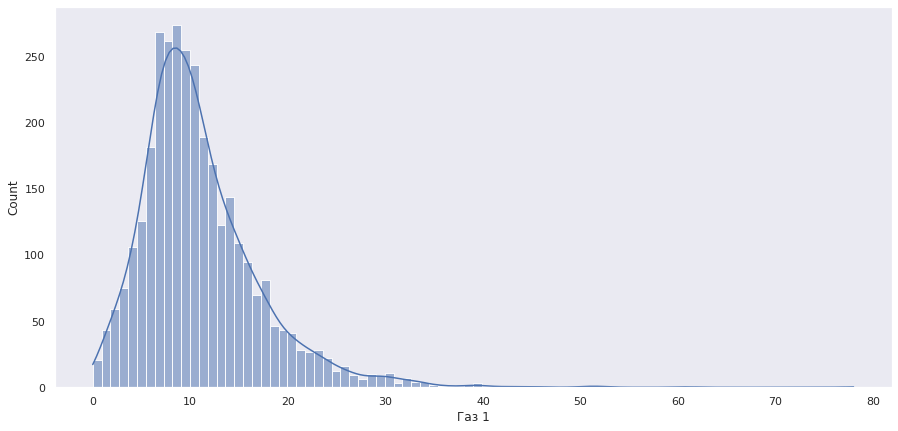

In [24]:
sns.set(rc={'figure.figsize': (15, 7)})
sns.set_style('dark')
sns.histplot(data=datasets['data_gas_new'], x='Газ 1', kde=True);

Распределение близко к нормальному с небольшим перекосом влево. В среднем металл продувают 10 кубометрами газа.

### data_temp_new

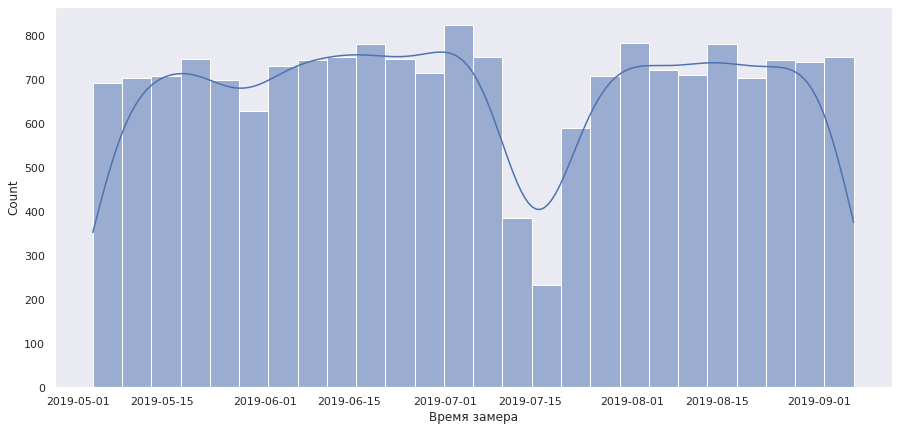

In [25]:
sns.set(rc={'figure.figsize': (15, 7)})
sns.set_style('dark')
sns.histplot(data=datasets['data_temp_new'], x='Время замера', kde=True);

Ожидаемо есть сильная просадка в показаниях в период с 14 по 17 число.

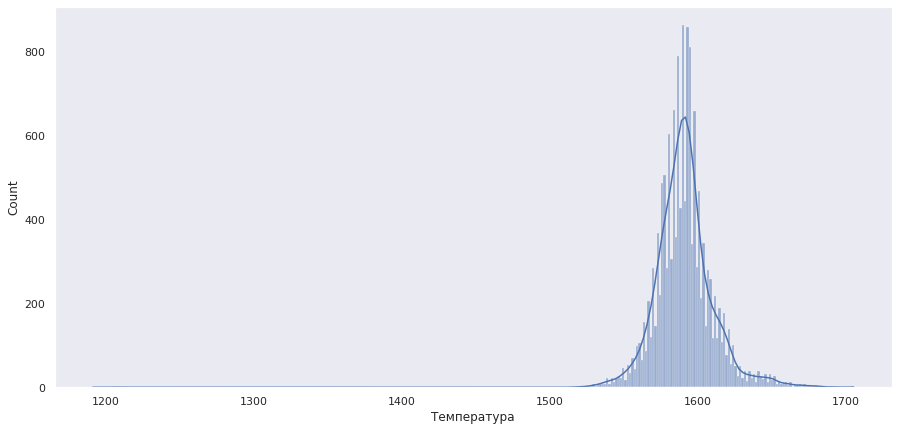

In [26]:
sns.set(rc={'figure.figsize': (15, 7)})
sns.set_style('dark')
sns.histplot(data=datasets['data_temp_new'], x='Температура', kde=True);

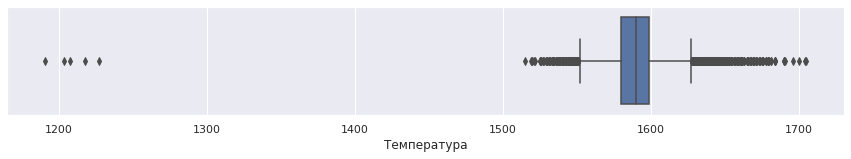

In [27]:
sns.set(rc={'figure.figsize': (15, 2)})
sns.boxplot(data=datasets['data_temp_new'], x='Температура');

Распределение похоже на нормальное, однако есть большой хвост с выбросами до 1500 градусов.

### data_wire_new

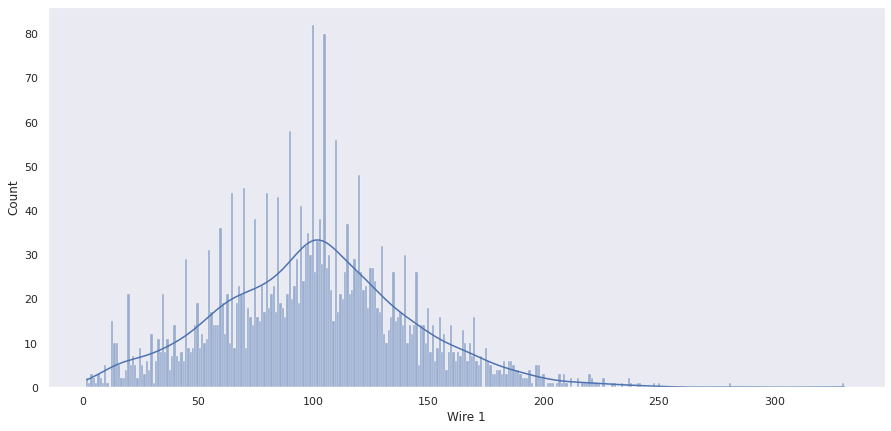

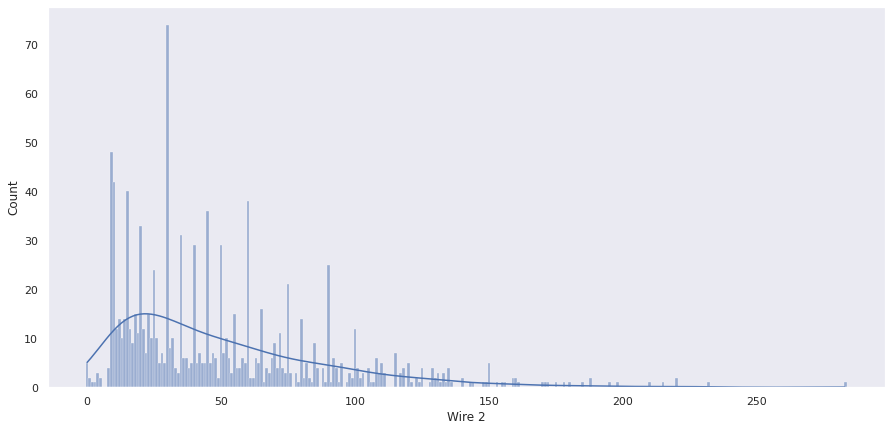

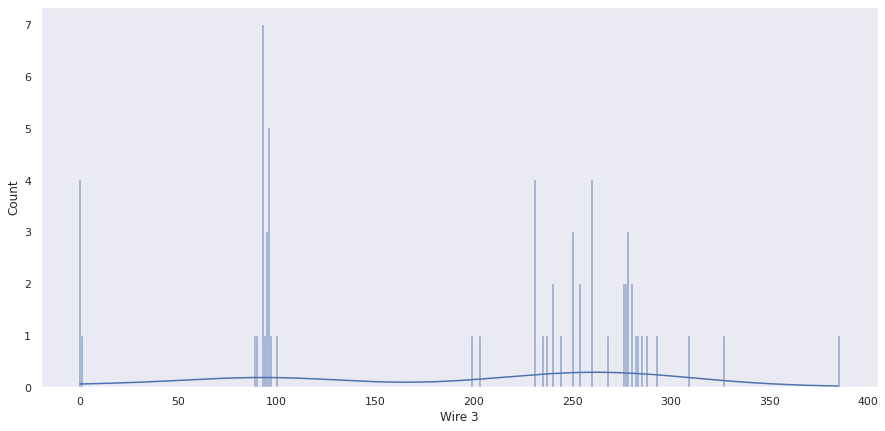

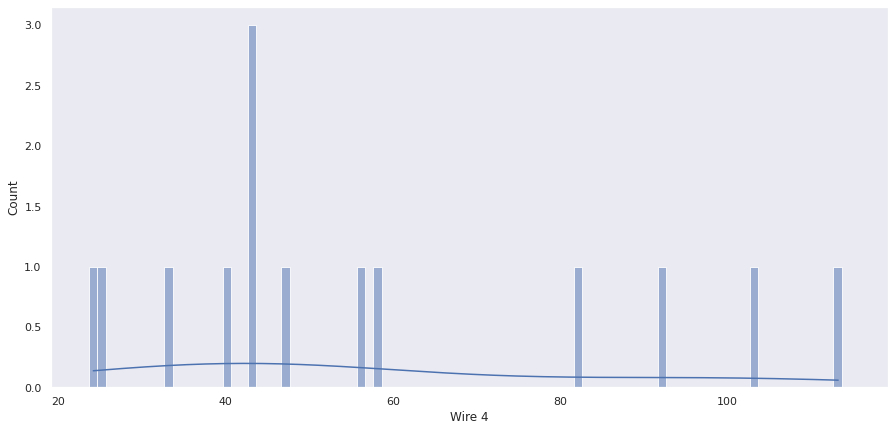

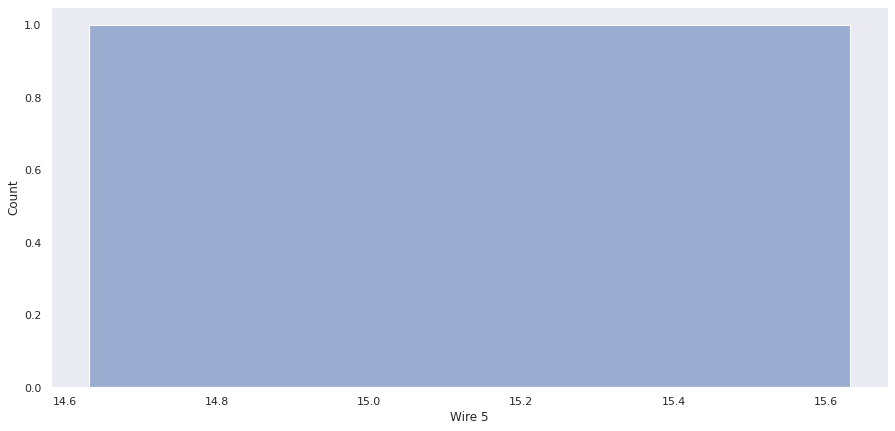

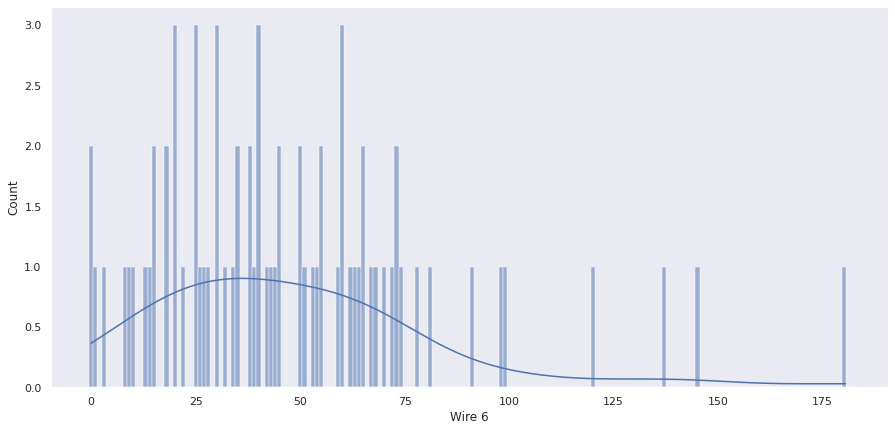

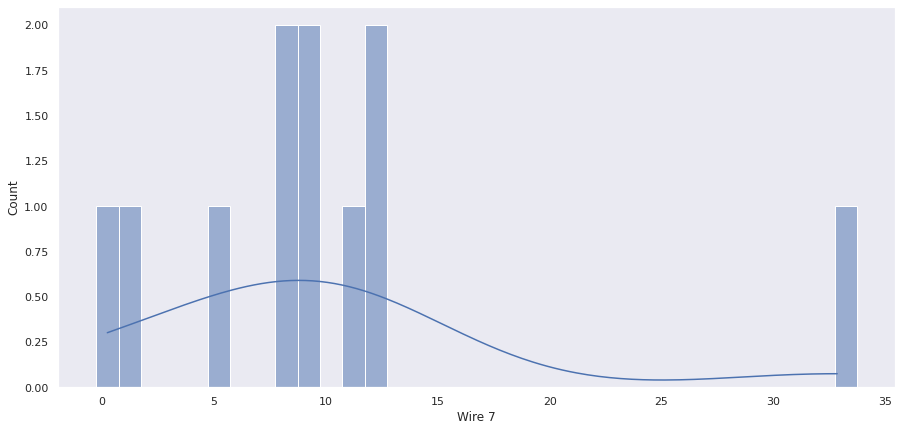

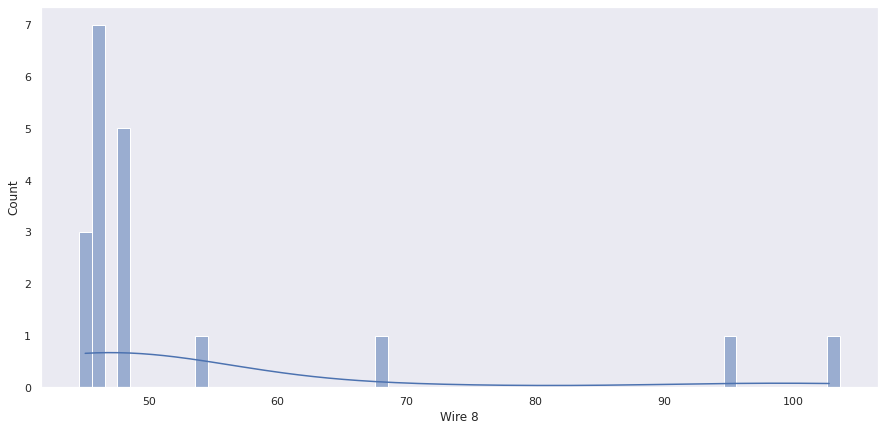

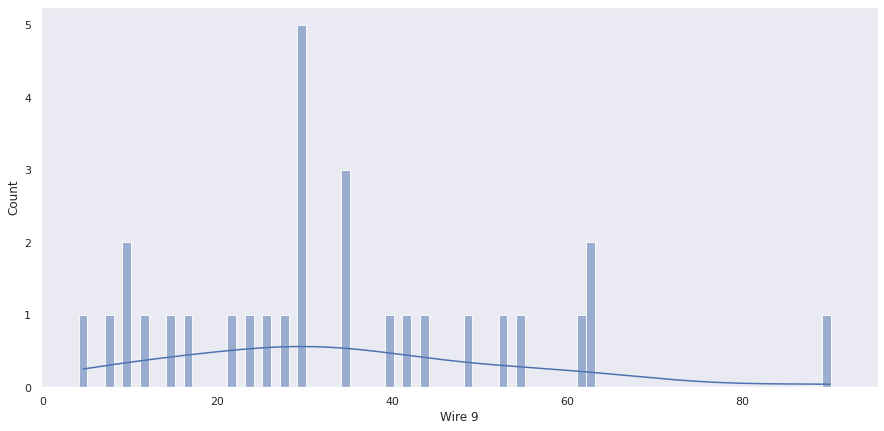

In [28]:
wires = datasets['data_wire_new'].columns.to_list()[1:]

for wire in wires:
    sns.set(rc={'figure.figsize': (15, 7)})
    sns.set_style('dark')
    sns.histplot(data=datasets['data_wire_new'], x=wire, kde=True, discrete=True)
    plt.show()

In [29]:
datasets['data_wire_new'].describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Аналогично, как и с сыпучими материалами, различные виды проволоки добавляются в различных количествах. Можно отметить, что `Wire 5` была добавлена всего один раз, при том, что `Wire 1` добавлялась практически в каждой партии.

### data_wire_time_new

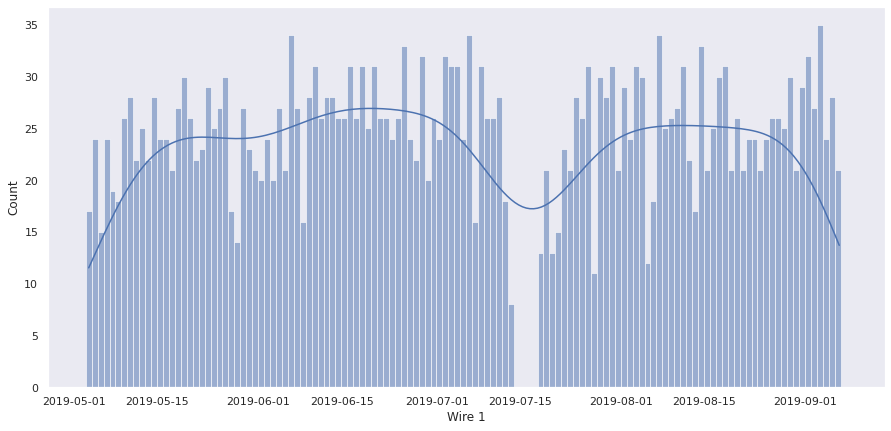

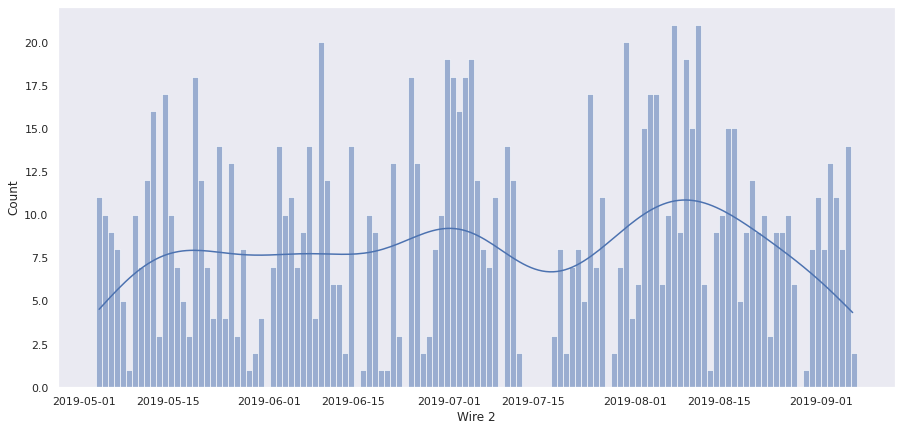

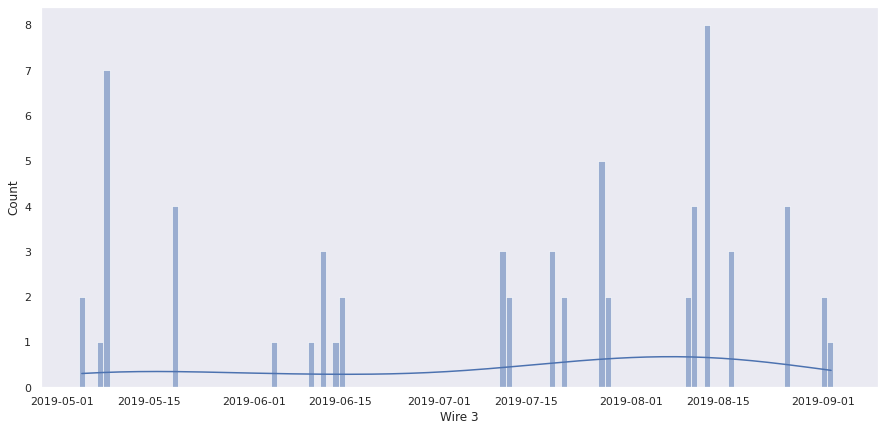

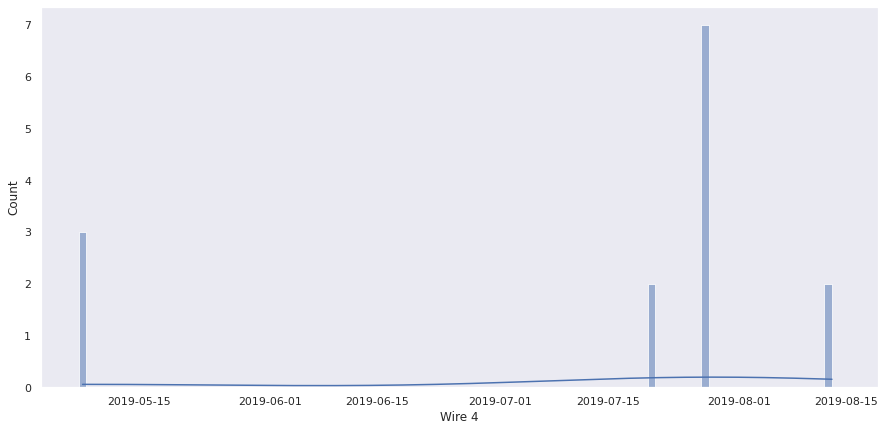

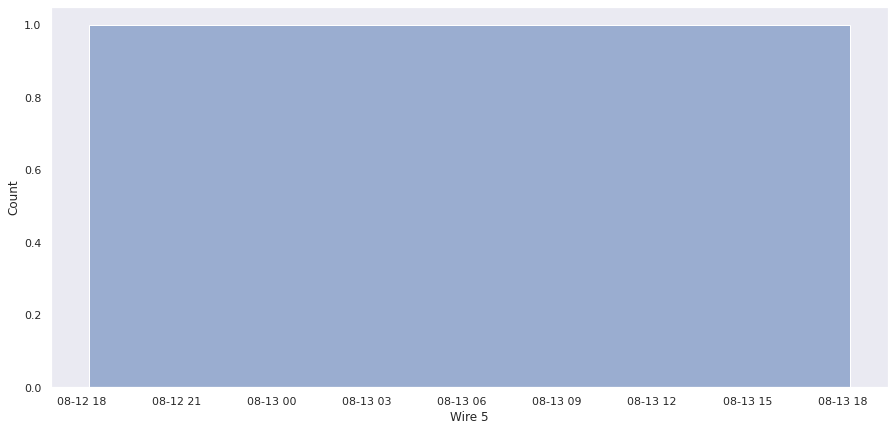

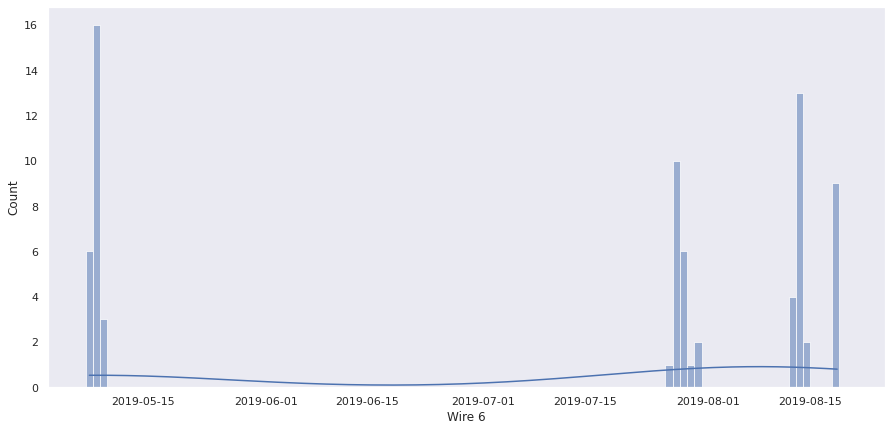

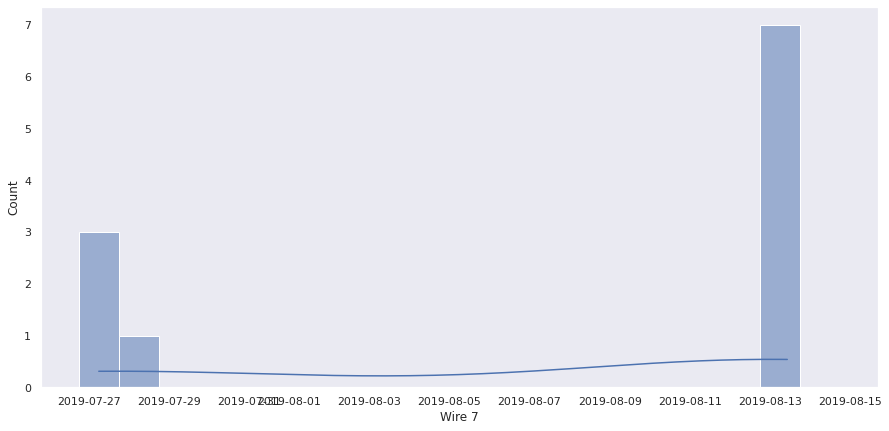

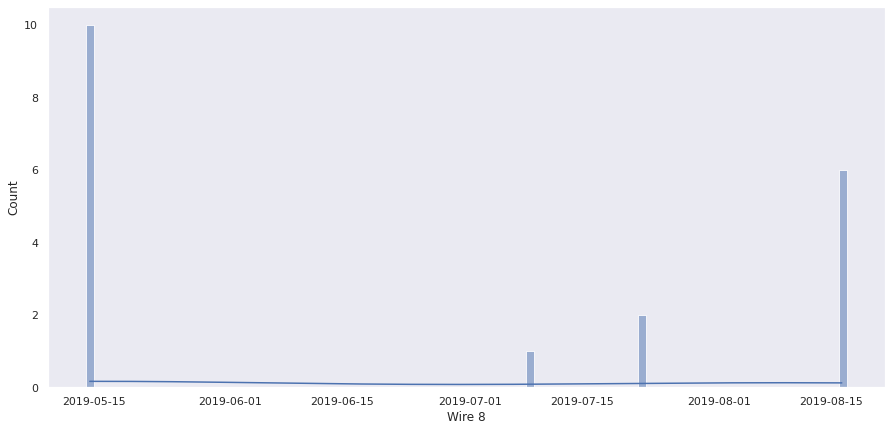

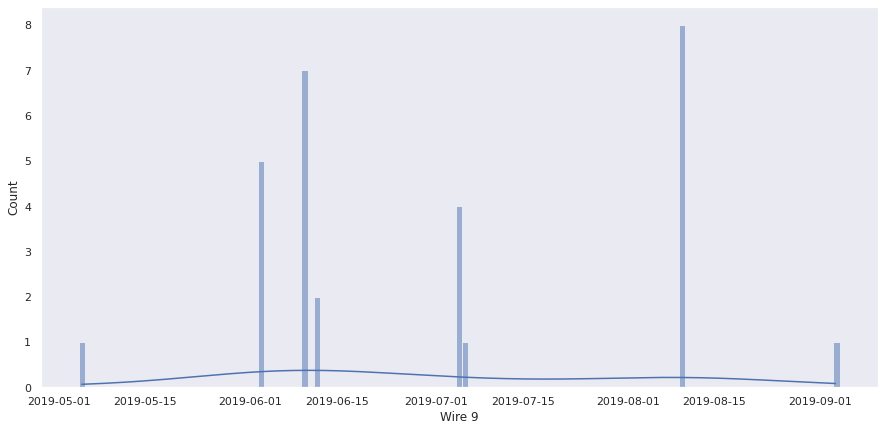

In [30]:
for wire in wires:
    sns.set(rc={'figure.figsize': (15, 7)})
    sns.set_style('dark')
    sns.histplot(data=datasets['data_wire_time_new'], x=wire, kde=True, discrete=True)
    plt.show()

Вполне закономерно наблюдается пропуск с 14 по 17 июля. Также видно, что разные проволоки добавляются с разной частотой.

## Вывод

- Во всех датасетах присутствуют пропуски за период с 14 по 17 июля. Эти пропуски заполнить не получится и на этапе предобработки их нужно будет удалить.
- В целевом признаке - температуре - присутствуют выбросы со значением менее 1400 градусов. Вероятно всего, их нужно будет удалить.
- Пропуски в данных, где не подавали проволоку и сыпучие материалы имеет смысл заполнить нулями.

## Предобработка данных

Для удобства вынес все датасеты в отдельные переменные.

In [31]:
data_arc = datasets['data_arc_new']
data_bulk = datasets['data_bulk_new']
data_bulk_time = datasets['data_bulk_time_new']
data_gas = datasets['data_gas_new']
data_temp = datasets['data_temp_new']
data_wire = datasets['data_wire_new']
data_wire_time = datasets['data_wire_time_new']

### data_temp

Удалим все промежуточные значения температур для каждого значения номера партии.

In [32]:
temp_first_last = pd.DataFrame()

for key in data_temp['key'].unique():
    sort_data = data_temp[data_temp['key'] == key].sort_values(by='Время замера')

    temp_first_last = temp_first_last.append(sort_data.head(1))
    temp_first_last = temp_first_last.append(sort_data.tail(1))

temp_first_last

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
10,2,2019-05-03 11:55:09,1602.0
11,3,2019-05-03 12:06:44,1596.0
...,...,...,...
18079,3239,2019-09-06 15:09:55,NaN
18080,3240,2019-09-06 15:25:21,1617.0
18085,3240,2019-09-06 16:35:26,NaN
18086,3241,2019-09-06 16:48:55,1586.0


Удалим из датафрейма все значения номеров партий, у которых имеются пропуски в температуре.

In [33]:
row = temp_first_last[temp_first_last['Температура'].isna()]['key']
temp_first_last = temp_first_last.query('key not in @row')
temp_first_last

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
10,2,2019-05-03 11:55:09,1602.0
11,3,2019-05-03 12:06:44,1596.0
...,...,...,...
13914,2497,2019-08-10 12:53:28,1589.0
13915,2498,2019-08-10 12:58:11,1591.0
13920,2498,2019-08-10 13:23:31,1594.0
13921,2499,2019-08-10 13:33:21,1569.0


Средняя температура плавления стали - 1400 градусов. Удалим из датафрейма все температуры, которые ниже этой границы.

In [34]:
row = temp_first_last[temp_first_last['Температура'] < 1400]['key']
temp_first_last = temp_first_last.query('key not in @row')
temp_first_last

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
10,2,2019-05-03 11:55:09,1602.0
11,3,2019-05-03 12:06:44,1596.0
...,...,...,...
13914,2497,2019-08-10 12:53:28,1589.0
13915,2498,2019-08-10 12:58:11,1591.0
13920,2498,2019-08-10 13:23:31,1594.0
13921,2499,2019-08-10 13:33:21,1569.0


In [35]:
temp_first_last.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4946 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           4946 non-null   int64         
 1   Время замера  4946 non-null   datetime64[ns]
 2   Температура   4946 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 154.6 KB


### data_bulk, data_wire

Заполним пропуски нулями.

In [36]:
data_bulk.fillna(0, inplace=True)
data_wire.fillna(0, inplace=True)

In [37]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   3129 non-null   float64
 2   Bulk 2   3129 non-null   float64
 3   Bulk 3   3129 non-null   float64
 4   Bulk 4   3129 non-null   float64
 5   Bulk 5   3129 non-null   float64
 6   Bulk 6   3129 non-null   float64
 7   Bulk 7   3129 non-null   float64
 8   Bulk 8   3129 non-null   float64
 9   Bulk 9   3129 non-null   float64
 10  Bulk 10  3129 non-null   float64
 11  Bulk 11  3129 non-null   float64
 12  Bulk 12  3129 non-null   float64
 13  Bulk 13  3129 non-null   float64
 14  Bulk 14  3129 non-null   float64
 15  Bulk 15  3129 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [38]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3081 non-null   float64
 2   Wire 2  3081 non-null   float64
 3   Wire 3  3081 non-null   float64
 4   Wire 4  3081 non-null   float64
 5   Wire 5  3081 non-null   float64
 6   Wire 6  3081 non-null   float64
 7   Wire 7  3081 non-null   float64
 8   Wire 8  3081 non-null   float64
 9   Wire 9  3081 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


### Вывод

- На этапе предобработки в датасете `data_temp` было сделано следующее:
    - удалены промежуточные замеры температуры для каждой партии;
    - удалены партии с пропусками данных в температуре;
    - удалены выбросы в значениях температуры.
- В датасетах `data_bulk` и `data_wire` пропуски в данных были заполнены нулевыми значениями.

## Подготовка общей таблицы

In [39]:
data_list = []

for key in temp_first_last['key'].unique():
    t = temp_first_last[temp_first_last['key'] == key].reset_index(drop=True)
    
    data_list.append([key, t.loc[0, 'Температура'], t.loc[1, 'Температура'],
                      (t.loc[1, 'Время замера'] - t.loc[0, 'Время замера']).seconds])
    
data_temp = pd.DataFrame(data_list, columns=['key', 'Температура в начале', 'Температура в конце', 'Время нагрева, с'])
data_temp

,key,Температура в начале,Температура в конце,"Время нагрева, с"
0,1,1571.0,1613.0,1714
1,2,1581.0,1602.0,1265
2,3,1596.0,1599.0,1753
3,4,1601.0,1625.0,1220
4,5,1576.0,1602.0,1536
...,...,...,...,...
2468,2495,1570.0,1591.0,1380
2469,2496,1554.0,1591.0,1705
2470,2497,1571.0,1589.0,962
2471,2498,1591.0,1594.0,1520


В датафрейме `data_arc` присутствует отрицательное значение реактивной мощности. Удалим его.

In [40]:
data_arc = data_arc[data_arc['Реактивная мощность'] > 0]
data_arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543


Теперь сосчитаем время нагрева для электродов по всем временным промежуткам.

In [41]:
data_arc['Время нагрева, с'] = (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']).dt.seconds
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,"Время нагрева, с"
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148


Рассчитаем затраты энергии.

In [42]:
data_arc['Затраты энергии'] = data_arc['Время нагрева, с'] *\
                            (data_arc['Активная мощность'] ** 2 + data_arc['Реактивная мощность'] ** 2) ** (0.5)
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,"Время нагрева, с",Затраты энергии
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228,84.616003
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185,166.928978
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172,124.276277
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365,234.630603
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148,159.830252


Теперь можно сгруппировать данные по номеру партии и вычислить общие затраты энергии для каждой.

In [43]:
data_arc_group = data_arc.groupby('key')['Затраты энергии'].agg('sum')
data_arc_group.to_frame()

,Затраты энергии
key,
1,770.282114
2,481.760005
3,722.837668
4,683.455597
5,512.169934
...,...
3237,630.503534
3238,286.052252
3239,941.538764


Объединяем датафреймы в один для дальнейшей работы с ними. Объединение производим по столбцу `key`.

In [44]:
data = data_temp.merge(right=data_arc_group, how='inner', on='key')\
    .merge(right=data_bulk, how='inner', on='key')\
    .merge(right=data_gas, how='inner', on='key')\
    .merge(right=data_wire, how='inner', on='key')

data

,key,Температура в начале,Температура в конце,"Время нагрева, с",Затраты энергии,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,1571.0,1613.0,1714,770.282114,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1581.0,1602.0,1265,481.760005,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1596.0,1599.0,1753,722.837668,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1601.0,1625.0,1220,683.455597,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1576.0,1602.0,1536,512.169934,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2320,2495,1570.0,1591.0,1380,694.177326,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0,7.125735,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2321,2496,1554.0,1591.0,1705,815.818538,0.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0,9.412616,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2322,2497,1571.0,1589.0,962,823.020520,0.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0,6.271699,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2323,2498,1591.0,1594.0,1520,581.810739,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0,14.953657,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
data.describe()

,key,Температура в начале,Температура в конце,"Время нагрева, с",Затраты энергии,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.0,2325.000000,2325.000000,2325.000000,2325.000000
mean,1251.512258,1587.365161,1593.366022,2323.419785,670.060566,3.433548,1.424946,47.296774,37.331613,2.644731,22.468817,2.008172,0.021075,0.445591,5.061505,4.252473,208.507957,1.069247,153.971613,120.026667,11.378942,102.412198,17.605637,3.240481,0.307077,0.0,0.980504,0.006371,0.311847,0.317658
std,715.099053,23.623144,11.209581,1385.569302,319.565380,12.421994,19.098442,75.228262,58.670377,22.421296,55.831097,30.702509,1.016213,6.225965,20.934742,22.534166,157.137873,14.247231,81.398153,84.674380,6.395632,43.535263,33.642919,27.966585,4.761821,0.0,8.700682,0.205882,4.406475,3.459510
min,1.000000,1519.000000,1541.000000,339.000000,33.430208,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008399,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,629.000000,1571.000000,1587.000000,1581.000000,457.872635,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,105.000000,0.000000,7.282948,73.207679,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,1255.000000,1587.000000,1593.000000,2046.000000,630.913482,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,149.000000,107.000000,10.100950,101.087998,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
75%,1868.000000,1603.000000,1598.000000,2793.000000,841.644330,0.000000,0.000000,80.000000,77.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,283.000000,0.000000,204.000000,204.000000,14.217691,128.069763,23.102560,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
max,2499.000000,1660.000000,1653.000000,23674.000000,4546.405812,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000,77.995040,330.314424,282.780152,385.008668,113.231044,0.0,180.454575,8.490040,102.762401,62.025600


Можно удалить столбец `Wire 5`, так как в нем содержатся только нули.

In [46]:
data.drop(['Wire 5'], axis=1, inplace=True)
data.head()

,key,Температура в начале,Температура в конце,"Время нагрева, с",Затраты энергии,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
0,1,1571.0,1613.0,1714,770.282114,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1581.0,1602.0,1265,481.760005,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1596.0,1599.0,1753,722.837668,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1601.0,1625.0,1220,683.455597,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1576.0,1602.0,1536,512.169934,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0


### Проверка корреляции признаков

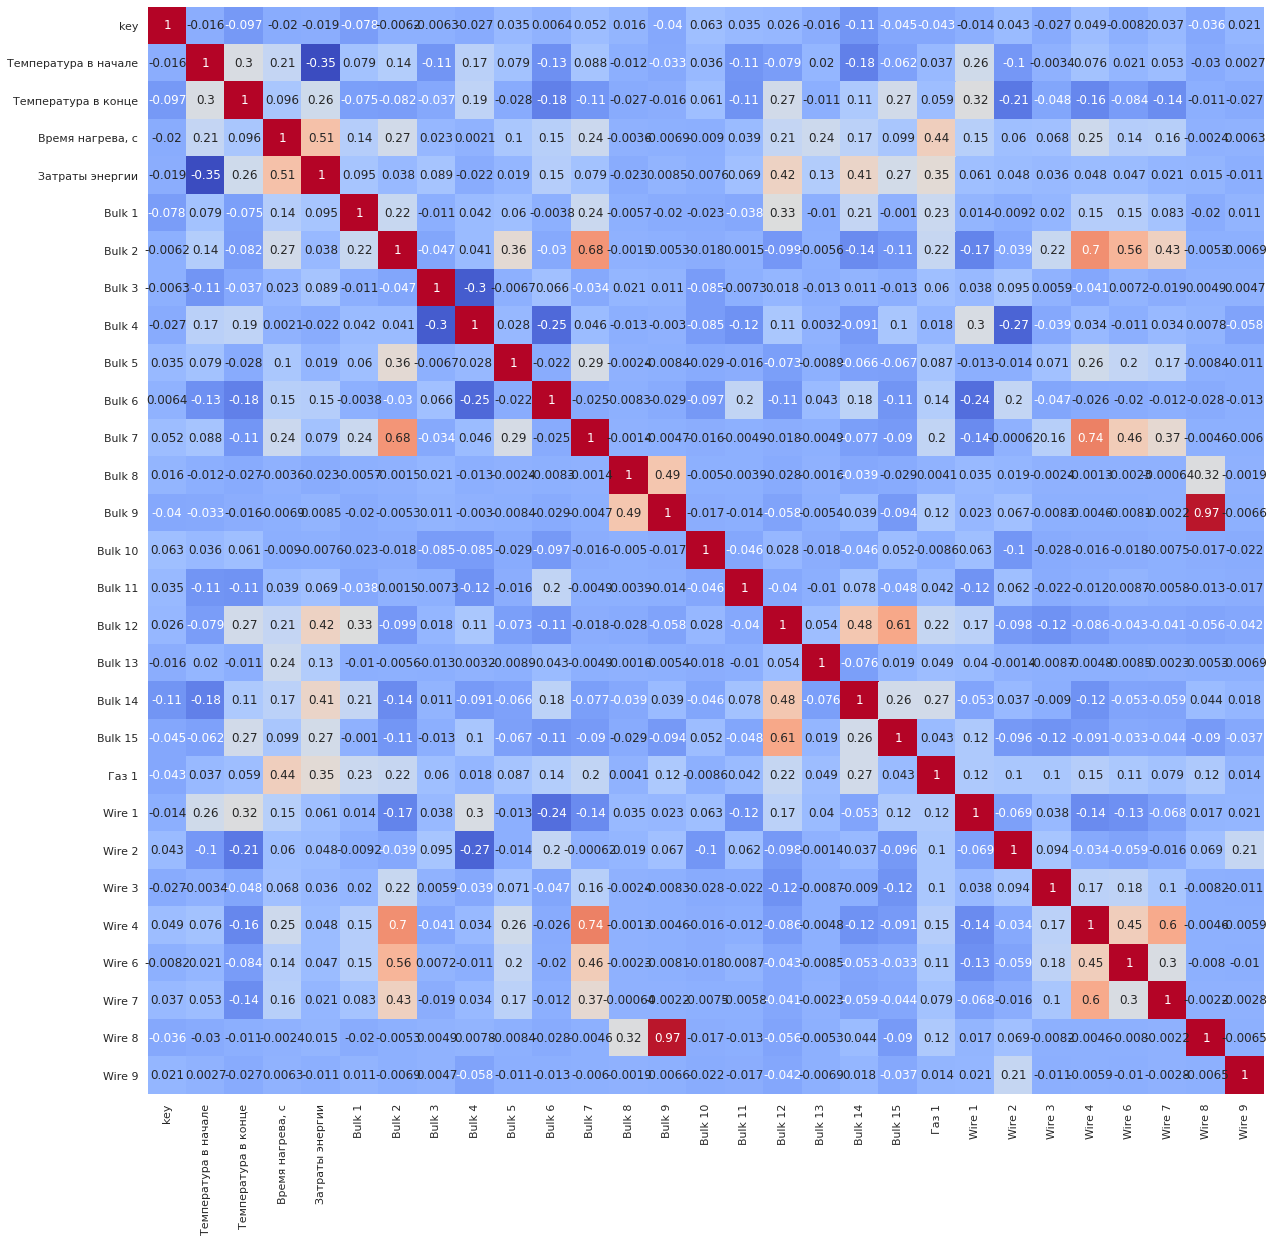

In [47]:
plt.figure(figsize=(20, 20))
sns.heatmap(data.corr(),
           annot=True,
           cmap='coolwarm',
           cbar=False);

In [48]:
data.corr()['Температура в конце'].sort_values(ascending=False)

Температура в конце     1.000000
Wire 1                  0.317702
Температура в начале    0.301961
Bulk 12                 0.267379
Bulk 15                 0.266386
Затраты энергии         0.256466
Bulk 4                  0.188100
Bulk 14                 0.114520
Время нагрева, с        0.096342
Bulk 10                 0.061345
Газ 1                   0.059036
Wire 8                 -0.010772
Bulk 13                -0.010925
Bulk 9                 -0.016081
Bulk 8                 -0.026590
Wire 9                 -0.027496
Bulk 5                 -0.028365
Bulk 3                 -0.036767
Wire 3                 -0.047548
Bulk 1                 -0.075233
Bulk 2                 -0.082466
Wire 6                 -0.084049
key                    -0.097052
Bulk 7                 -0.107289
Bulk 11                -0.114777
Wire 7                 -0.137275
Wire 4                 -0.159737
Bulk 6                 -0.181880
Wire 2                 -0.206837
Name: Температура в конце, dtype: float64

Целевой признак, температура в конце, наиболее сильно коррелирует со следующими параметрами:
- Wire 1
- Температура в начале
- Bulk 12
- Bulk 15
- Затраты энергии

однако стоит отметить, что зависимость не очень сильная.

По тепловой карте можно заметить очень сильную зависимость между `Wire 8` и `Bulk 9`. Также видна зависимость между `Wire 4` и `Bulk 2`; `Wire 4` и `Bulk 7`.

### Вывод

- При формировании общей таблицы признаков датафреймы были объединены по номеру партии `key`.
- Были вычислены общие затраты энергии для каждой партии и вынесены в отдельный столбец.
- Из общей таблицы был удален столбец `Wire 5`, так как он не содержал никакой информации.
- Было проведено исследование корреляции признаков между собой. Выяснились следующие моменты:
    - Наблюдается практически прямая зависимость между `Wire 8` и `Bulk 9`;
    - Видна сильная зависимость между `Wire 4` и `Bulk 2`; `Wire 4` и `Bulk 7`.
- Также проведен анализ корреляции целевого признака с остальными параметрами. Выяснилось, что наиболее сильно он коррелирует со следующими признаками:
    - Wire 1
    - Температура в начале
    - Bulk 12
    - Bulk 15
    - Затраты энергии

## Разделение на выборки

In [49]:
features = data.drop(['Температура в конце', 'key'], axis=1)
target = data['Температура в конце']

In [50]:
print('features:', features.shape)
print('target:', target.shape)

features: (2325, 27)
target: (2325,)


In [51]:
features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                            test_size=0.25, random_state=RANDOM_STATE)

print('features_train:', features_train.shape)
print('target_train:', target_train.shape)
print('features_test:', features_test.shape)
print('target_test:', target_test.shape)

features_train: (1743, 27)
target_train: (1743,)
features_test: (582, 27)
target_test: (582,)


In [52]:
scaler = StandardScaler()

scaler.fit(features_train)

features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

features_train = pd.DataFrame(features_train, columns=features.columns)

## Обучение моделей

In [53]:
def best_hyperparams(estimator, grid_space):    
    grid = GridSearchCV(estimator=estimator,
                        param_grid=grid_space,
                        cv=5,
                        scoring='neg_mean_absolute_error',
                        verbose=100)

    grid.fit(features_train, target_train)
    
    return grid

In [54]:
comp_table = {}

### Линейная регрессия

Для линейной регрессии удалим сильно коррелирующие между собой столбцы.

In [55]:
features_train_linear = features_train.drop(['Wire 4', 'Wire 8'], axis=1)

print('features_train_linear:', features_train_linear.shape)

features_train_linear: (1743, 25)


In [56]:
%%time

score = cross_val_score(LinearRegression(), features_train_linear, target_train,
                        cv=5,
                        scoring='neg_mean_absolute_error').mean()

CPU times: user 86 ms, sys: 163 ms, total: 249 ms
Wall time: 143 ms


In [57]:
comp_table['linear'] = abs(score)

print('best MAE', abs(score))

best MAE 6.731925267064523


### Дерево решений

In [58]:
grid_space = {'max_depth': range(1, 51),}

In [59]:
%%time

grid = best_hyperparams(DecisionTreeRegressor(random_state=RANDOM_STATE), grid_space)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5; 1/50] START max_depth=1................................................
[CV 1/5; 1/50] END ..............................max_depth=1; total time=   0.0s
[CV 2/5; 1/50] START max_depth=1................................................
[CV 2/5; 1/50] END ..............................max_depth=1; total time=   0.0s
[CV 3/5; 1/50] START max_depth=1................................................
[CV 3/5; 1/50] END ..............................max_depth=1; total time=   0.0s
[CV 4/5; 1/50] START max_depth=1................................................
[CV 4/5; 1/50] END ..............................max_depth=1; total time=   0.0s
[CV 5/5; 1/50] START max_depth=1................................................
[CV 5/5; 1/50] END ..............................max_depth=1; total time=   0.0s
[CV 1/5; 2/50] START max_depth=2................................................
[CV 1/5; 2/50] END ............................

In [60]:
comp_table['tree'] = abs(grid.best_score_)

print('best params:', grid.best_params_)
print('best MAE:', abs(grid.best_score_))

best params: {'max_depth': 5}
best MAE: 7.448571075907246


### Случайный лес

In [61]:
grid_space = {'max_depth': range(1, 20),
             'n_estimators': range(10, 110, 10),}

In [62]:
%%time

grid = best_hyperparams(RandomForestRegressor(random_state=RANDOM_STATE), grid_space)

Fitting 5 folds for each of 190 candidates, totalling 950 fits
[CV 1/5; 1/190] START max_depth=1, n_estimators=10..............................
[CV 1/5; 1/190] END ............max_depth=1, n_estimators=10; total time=   0.0s
[CV 2/5; 1/190] START max_depth=1, n_estimators=10..............................
[CV 2/5; 1/190] END ............max_depth=1, n_estimators=10; total time=   0.0s
[CV 3/5; 1/190] START max_depth=1, n_estimators=10..............................
[CV 3/5; 1/190] END ............max_depth=1, n_estimators=10; total time=   0.0s
[CV 4/5; 1/190] START max_depth=1, n_estimators=10..............................
[CV 4/5; 1/190] END ............max_depth=1, n_estimators=10; total time=   0.0s
[CV 5/5; 1/190] START max_depth=1, n_estimators=10..............................
[CV 5/5; 1/190] END ............max_depth=1, n_estimators=10; total time=   0.0s
[CV 1/5; 2/190] START max_depth=1, n_estimators=20..............................
[CV 1/5; 2/190] END ............max_depth=1, n

In [63]:
comp_table['forest'] = abs(grid.best_score_)

print('best params:', grid.best_params_)
print('best MAE:', abs(grid.best_score_))

best params: {'max_depth': 10, 'n_estimators': 100}
best MAE: 6.590804126206042


### CatBoost

In [64]:
grid_space = {'n_estimators': range(100, 1100, 100),
              'max_depth': range(2, 11),}

In [65]:
%%time

grid = best_hyperparams(CatBoostRegressor(random_state=RANDOM_STATE, learning_rate=0.1, verbose=100), grid_space)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
[CV 1/5; 1/90] START max_depth=2, n_estimators=100..............................
0:	learn: 11.2179764	total: 47ms	remaining: 4.65s
99:	learn: 8.1467052	total: 98.6ms	remaining: 0us
[CV 1/5; 1/90] END ............max_depth=2, n_estimators=100; total time=   0.7s
[CV 2/5; 1/90] START max_depth=2, n_estimators=100..............................
0:	learn: 11.1258786	total: 774us	remaining: 76.7ms
99:	learn: 8.1815833	total: 57.5ms	remaining: 0us
[CV 2/5; 1/90] END ............max_depth=2, n_estimators=100; total time=   0.6s
[CV 3/5; 1/90] START max_depth=2, n_estimators=100..............................
0:	learn: 11.3523863	total: 684us	remaining: 67.8ms
99:	learn: 8.0429299	total: 53.7ms	remaining: 0us
[CV 3/5; 1/90] END ............max_depth=2, n_estimators=100; total time=   0.6s
[CV 4/5; 1/90] START max_depth=2, n_estimators=100..............................
0:	learn: 11.0993929	total: 758us	remaining: 75.1ms
99:	learn: 8.38

In [66]:
comp_table['catboost'] = abs(grid.best_score_)

print('best params:', grid.best_params_)
print('best MAE:', abs(grid.best_score_))

best params: {'max_depth': 2, 'n_estimators': 700}
best MAE: 6.409015977472572


In [67]:
pd.DataFrame(comp_table, index=['MAE'])

,linear,tree,forest,catboost
MAE,6.731925,7.448571,6.590804,6.409016


### Вывод

На обучение были взяты четыре модели: `LinearRegression`, `DecisionTreeRegressor`, `RandomForest` и `CatBoost`. Для всех моделей, кроме линейной регрессии, были подобраны оптимальные гиперпараметры. Для линейной регресии была проведена кросс-валидация. Результаты получились следующие:
- DecisionTreeRegressor: `max_depth` = 5;
- RandomForest: `n_estimators` = 100, `max_depth` = 10;
- CatBoost: `n_estimators` = 700, `max_depth` = 2.

Наилучшие результаты с оптимальными гиперпараметрами показала модель `CatBoost`. Значение целевой метрики `MAE` на обучающих данных равно `6.41`, что является наилучшим результатом среди выбранных моделей. Берем эту модель для дальнейшего тестирования.

## Тестирование лучшей модели

In [68]:
model = CatBoostRegressor(random_state=RANDOM_STATE, learning_rate=0.1, verbose=100,
                         max_depth=2, n_estimators=700)

model.fit(features_train, target_train)

0:	learn: 11.2400407	total: 783us	remaining: 548ms
100:	learn: 8.2604184	total: 64.5ms	remaining: 383ms
200:	learn: 7.6344523	total: 129ms	remaining: 319ms
300:	learn: 7.2824183	total: 201ms	remaining: 266ms
400:	learn: 6.9943062	total: 264ms	remaining: 197ms
500:	learn: 6.7787511	total: 325ms	remaining: 129ms
600:	learn: 6.6023418	total: 388ms	remaining: 64ms
699:	learn: 6.4493617	total: 450ms	remaining: 0us


In [69]:
predictions = model.predict(features_test)

print('MAE на тестовой выборке:', mean_absolute_error(target_test, predictions))

MAE на тестовой выборке: 6.320000708655136


## Проверка модели на адекватность

In [70]:
dummy_model = DummyRegressor()

dummy_model.fit(features_train, target_train)
prediction = dummy_model.predict(features_test)

print('MAE на dummy-модели:', mean_absolute_error(target_test, prediction))

MAE на dummy-модели: 7.800871625924421


Значение `MAE` на модели `DummyRegressor` получились выше, чем у модели `CatBoost` с подобранными гиперпараметрами. Следовательно, модель прошла проверку на адекватность.

## Исследование важности факторов

In [71]:
feature_result = pd.DataFrame({'feature': list(features.columns),
                              'importance': model.feature_importances_})
feature_result = feature_result.sort_values(by='importance', ascending=False).reset_index(drop=True)

feature_result

,feature,importance
0,Температура в начале,22.124766
1,Затраты энергии,21.618164
2,Wire 1,9.092724
3,Wire 2,5.783189
4,"Время нагрева, с",5.734676
5,Bulk 6,5.699897
6,Bulk 12,5.252563
7,Bulk 15,5.164756
8,Bulk 14,4.429387
9,Газ 1,3.484669


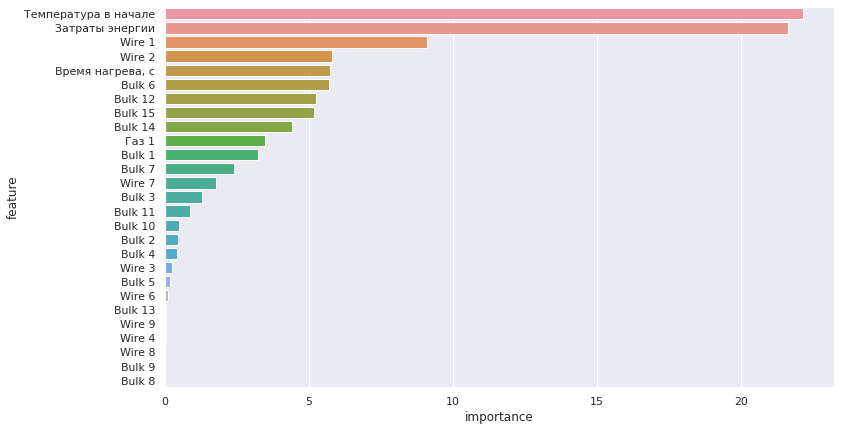

In [72]:
sns.set(rc={'figure.figsize': (12, 7)})
sns.barplot(data=feature_result, x='importance', y='feature');

### Вывод

- По графику видно, что наиболее важными для модели являются следующие факторы: `Температура в начале`, `Затраты энергии`, `Wire 1` и `Wire 2`;
- Наименее важными - `Bulk 8`, `Bulk 9`, `Wire 8`, `Wire 4`, `Wire 9` и `Bulk 13`.

## Отчет

Было проведено исследование, целью которого было построить модель, которая предскажет температуру стали.

1. Можно выделить несколько ключевых блоков в данной работе:
- Графический анализ, благодаря которому было обнаружено остутствие данных за 14-17 июля.
- Предварительная обработка, в ходе которой данные были обработаны: заполнены пропуски, удалены некорректные значения и выбросы.
- Обучение моделей с подбором оптимальных гиперпараметров и выбор наилучшей модели для дальнейшего тестирования.

2. В нашем распоряжении были данные, которые требовали предварительной обработки. В результате этого процесса было выполнено следующее:
- Для датасета `data_temp`:
    - удалены промежуточные замеры температуры для каждой партии;
    - удалены партии с пропусками данных в температуре;
    - удалены выбросы в значениях температуры (значения меньше 1400 градусов).
- В датасетах `data_bulk` и `data_wire` пропуски в данных были заполнены нулевыми значениями.
- В датасете `data_arc` было удалено отрицательное значение мощности.
- Во всех датасетах были пропуски в период с 14 по 17 июля. Такие пропуски заполнять было нечем и впоследствие они были удалены из финальной таблицы.

В дальнейшем была подготовлена общая таблица, в которой датафреймы были объединены по номеру партии `key`. Также были рассчитаны общие затраты энергии для каждой партии и удален столбец `Wire 5`, так как не содержал какой-либо полезной информации. Также было проведено исследование корреляции признаков, результаты которого описаны в п. `7.2`.

3. Для обучения моделей данные были разделены на обучающую и тестовую выборки в соотношении 3:1, проведено масштабирование признаков.

На обучение были взяты четыре модели: `LinearRegression`, `DecisionTreeRegressor`, `RandomForest` и `CatBoost`. Для них подобраны оптимальные гиперпараметры и выбрана наилучшая модель по значению целевой метрики `MAE`.

Для тестирования была выбрана модель `CatBoost` с подобранными гиперпараметрами: `n_estimators` = 700, `max_depth` = 2. На тестовых данных модель показала значение `MAE` = 6.3, что соответствует требованиям заказчика (MAE <= 6.8).

Также была проведена проверка модели на адекватность с помощью `DummyRegressor`. Модель проверку прошла.

В финале был проведен анализ важности факторов для модели. Результаты получились следующие:
- Наиболее важными для модели являются факторы: `Температура в начале`, `Затраты энергии`, `Wire 1` и `Wire 2`;
- Наименее важными - `Bulk 8`, `Bulk 9`, `Wire 8`, `Wire 4`, `Wire 9` и `Bulk 13`.